- João Pedro Quintero Cabral - 2023001479 
- Lucas Galvão Freitas - 2023001147


In [279]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV,
    StratifiedKFold
)

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix
)

warnings.filterwarnings("ignore")


### 1. Carreguando os dados

In [280]:
df = pd.read_csv("Healthcare-Diabetes.csv")
df = df.drop('Id', axis=1)

df = df.drop_duplicates()

print(f"Linhas restantes após remover duplicatas: {len(df)}")
df.head()

Linhas restantes após remover duplicatas: 778


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [281]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 778 entries, 0 to 2336
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               778 non-null    int64  
 1   Glucose                   778 non-null    int64  
 2   BloodPressure             778 non-null    int64  
 3   SkinThickness             778 non-null    int64  
 4   Insulin                   778 non-null    int64  
 5   BMI                       778 non-null    float64
 6   DiabetesPedigreeFunction  778 non-null    float64
 7   Age                       778 non-null    int64  
 8   Outcome                   778 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 60.8 KB


### 2. Limpeza e Pré-processamento de dados

#### 2.1 Limpeza dos dados

In [282]:
df_clean = df.copy()

# Colunas onde zero significa dado ausente
cols_with_missing = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Substituir zeros por NaN
df_clean[cols_with_missing] = df[cols_with_missing].replace(0, pd.NA)

# Converter explicitamente para float
df_clean[cols_with_missing] = df_clean[cols_with_missing].apply(pd.to_numeric, errors='coerce')

In [283]:
df_clean.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                36
SkinThickness               229
Insulin                     377
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

Valores como 0 em "Glicose" ou "IMC" são biologicamente impossíveis, ou seja, são dados faltantes (erros). Substituímos pela mediana (e não pela média) porque a mediana é menos afetada por outliers (valores extremos), mantendo a integridade dos dados médicos.

In [284]:
for col in cols_with_missing:
    df_clean[col] = df_clean[col].fillna(df[col].median())

df_clean.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [285]:
df_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,778.0,3.821337,3.360794,0.000,1.000,3.0000,6.00000,17.00
Glucose,778.0,121.951157,30.470235,44.000,100.000,117.0000,141.00000,199.00
BloodPressure,778.0,72.307198,12.166561,24.000,64.000,72.0000,80.00000,122.00
SkinThickness,778.0,27.533419,9.756075,7.000,23.000,23.0000,32.00000,110.00
Insulin,778.0,97.832905,103.763754,14.000,36.000,36.0000,130.00000,846.00
BMI,778.0,32.641452,7.254245,18.200,27.600,32.2750,36.77500,80.60
DiabetesPedigreeFunction,778.0,0.471861,0.330180,0.078,0.244,0.3745,0.62675,2.42
Age,778.0,33.347044,11.789024,21.000,24.000,29.0000,41.00000,81.00
Outcome,778.0,0.349614,0.477155,0.000,0.000,0.0000,1.00000,1.00


In [286]:
df_clean.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,36.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,36.0,26.6,0.351,31,0
2,8,183.0,64.0,23.0,36.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


#### 2.2 Tratamento de outliers

**Por que não remover outliers neste dataset?**

Os “outliers” deste dataset representam casos clínicos reais, especialmente pacientes com glicose, insulina ou BMI muito elevados — justamente os casos de maior risco que o modelo precisa aprender a identificar. Removê-los elimaria sinais importantes da doença e reduziria o recall da classe positiva. Por isso, em dados médicos, mantemos os outliers e apenas aplicamos escalonamento robusto.

Robust Scalaer explicaçãoo ...

### 3. Análise exploratória

#### 3.1 Distribuição dos dados

In [287]:
sns.set_theme(style="whitegrid", palette="muted")

df_clean_analysis = df_clean.drop(columns='Outcome')

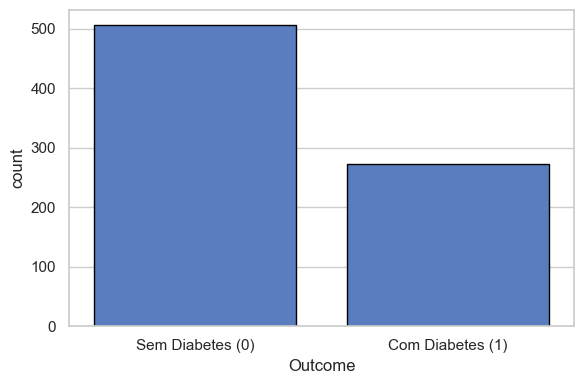

In [288]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df_clean, x='Outcome', edgecolor='black')

ax.set_xticklabels(['Sem Diabetes (0)', 'Com Diabetes (1)'])

plt.tight_layout()
plt.show()

Talvez seja interessante usar class_weight='balanced'

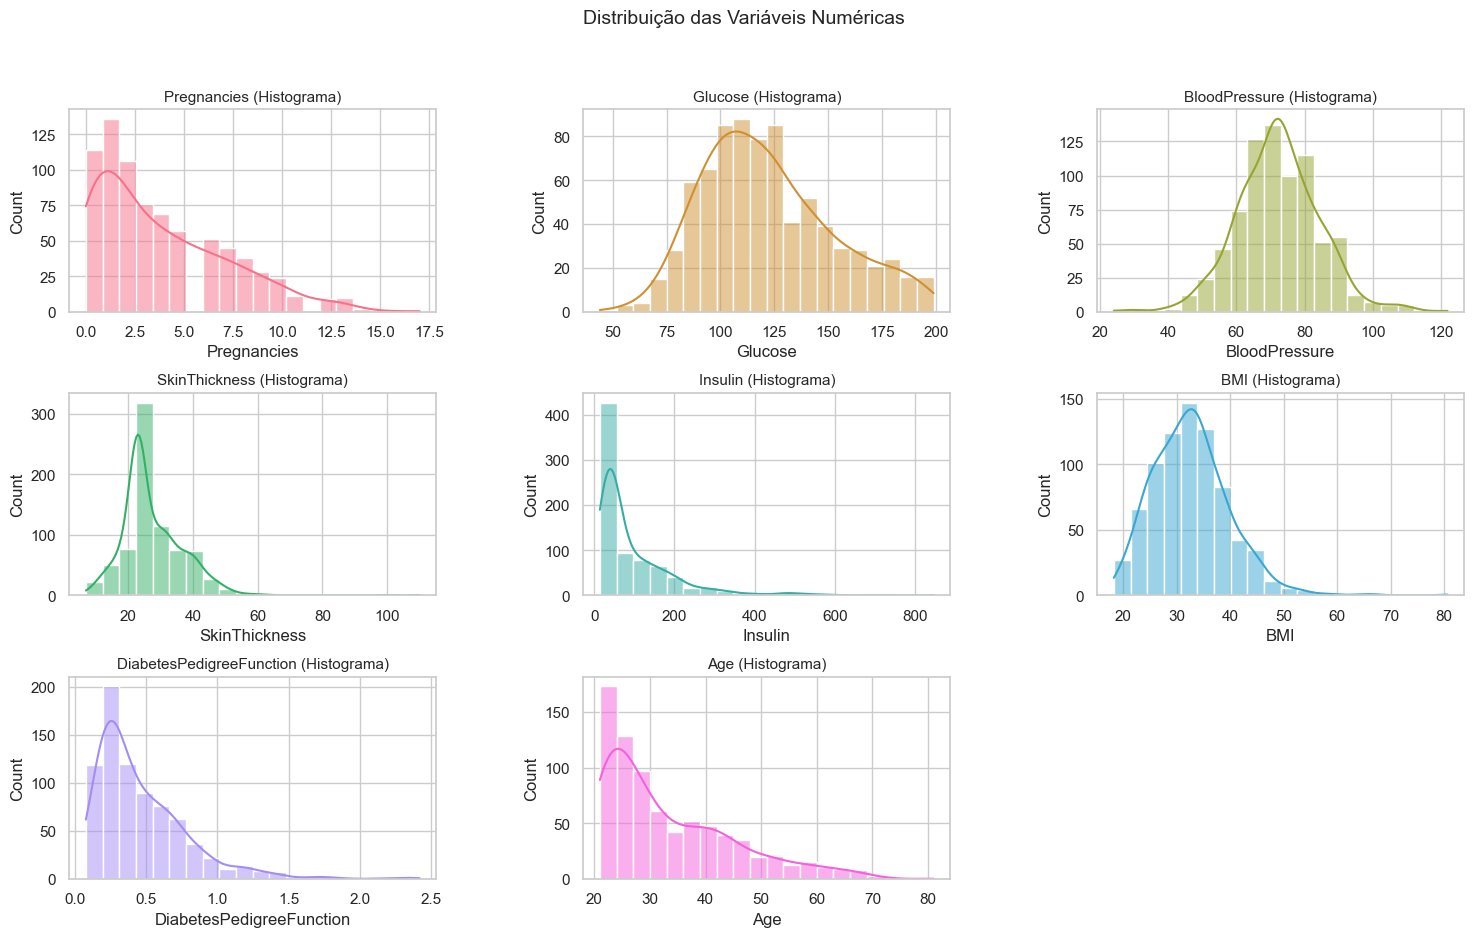

In [289]:
cols = df_clean.columns.drop('Outcome')
num_cols = cols.tolist()

fig, axes = plt.subplots(3, 3, figsize=(18, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

colors = sns.color_palette("husl", len(num_cols))

for i, (col, color) in enumerate(zip(num_cols, colors)):
    row = i // 3    
    col_idx = i % 3   

    sns.histplot(df_clean[col], ax=axes[row, col_idx], color=color, kde=True, bins=20)
    axes[row, col_idx].set_title(f'{col} (Histograma)', fontsize=11)

total_plots = len(num_cols)
for j in range(total_plots, 9):
    fig.delaxes(axes[j//3, j%3])

fig.suptitle('Distribuição das Variáveis Numéricas', fontsize=14)
plt.show()

A maioria dos dados não seguem uma distribuição normal

#### 3.3 Comparação das variáveis por Status da Doença

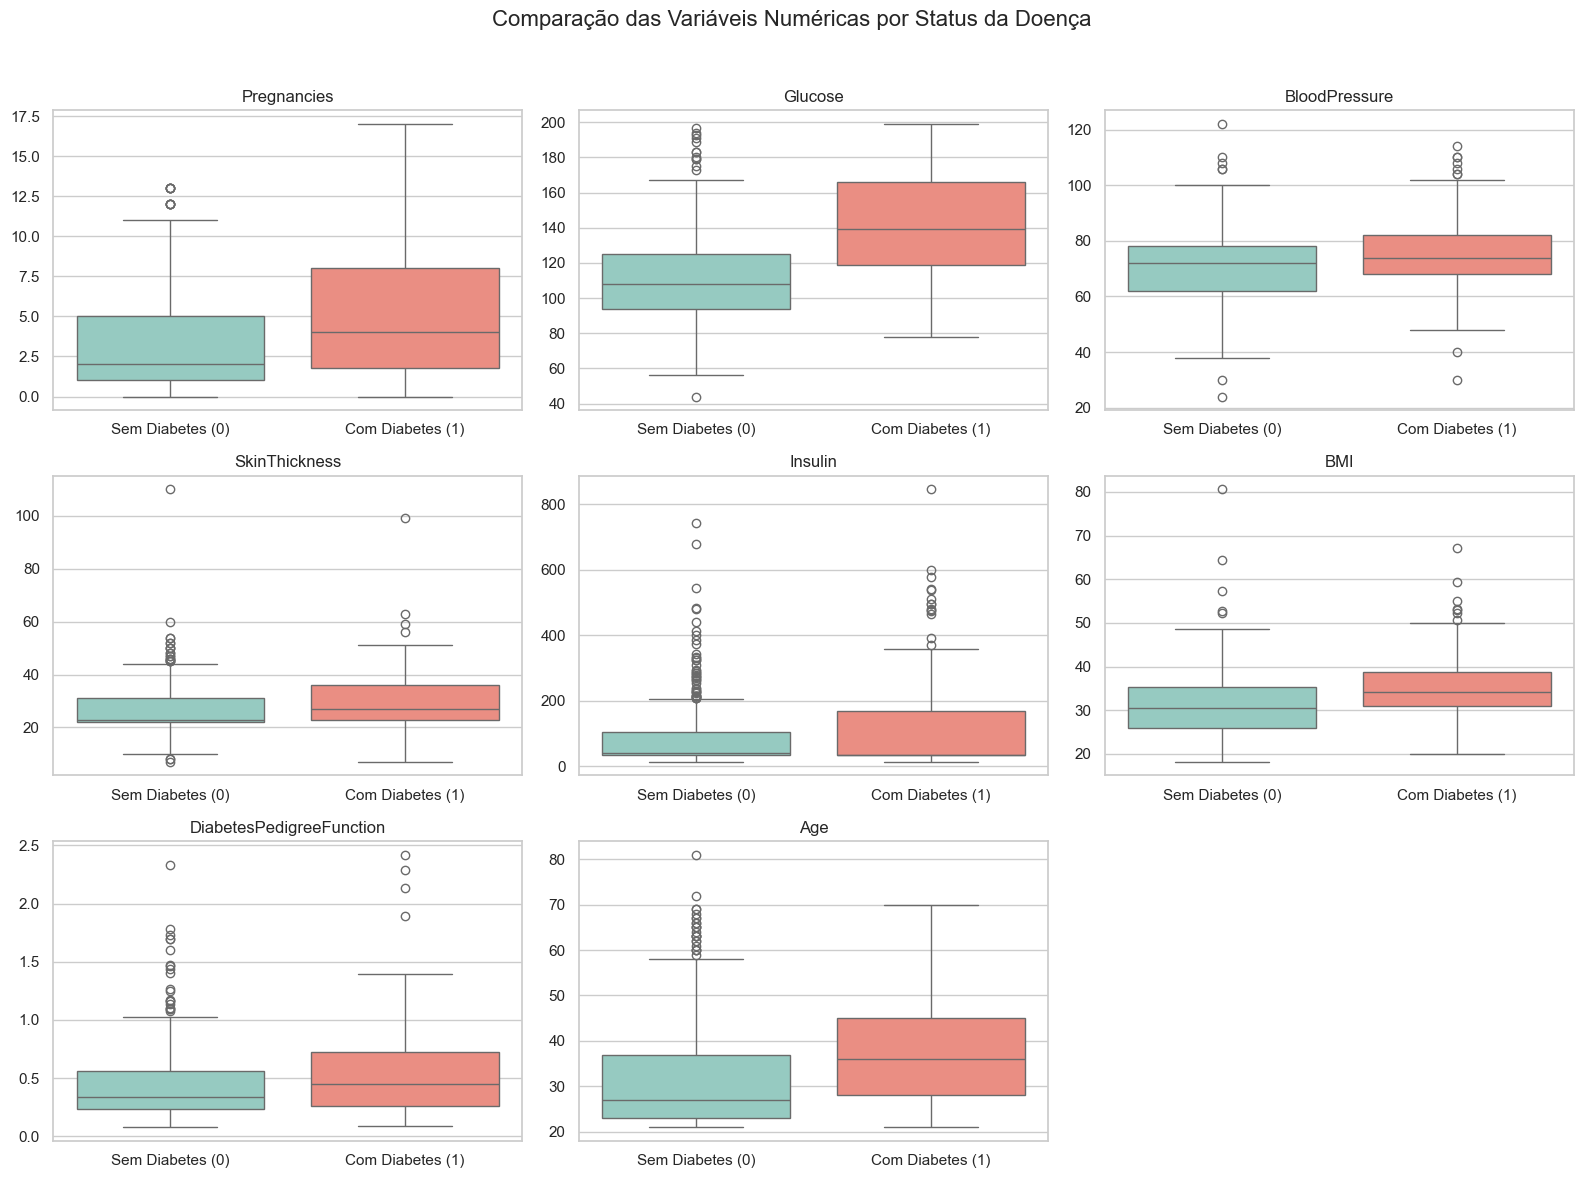

In [290]:
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

palette = ["#8dd3c7", "#fb8072"]

for i, col in enumerate(num_cols):
    ax = axes[i]
    
    sns.boxplot(
        x=df_clean["Outcome"],
        y=df_clean[col],
        ax=ax,
        palette=palette
    )
    
    ax.set_title(f'{col}', fontsize=12)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Sem Diabetes (0)', 'Com Diabetes (1)'])

# Remove eixos extras
for j in range(len(num_cols), 9):
    fig.delaxes(axes[j])

fig.suptitle('Comparação das Variáveis Numéricas por Status da Doença', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Todas colunas são determinantes para dizer se há ou não Diabetes, é claro que umas mais que outras.

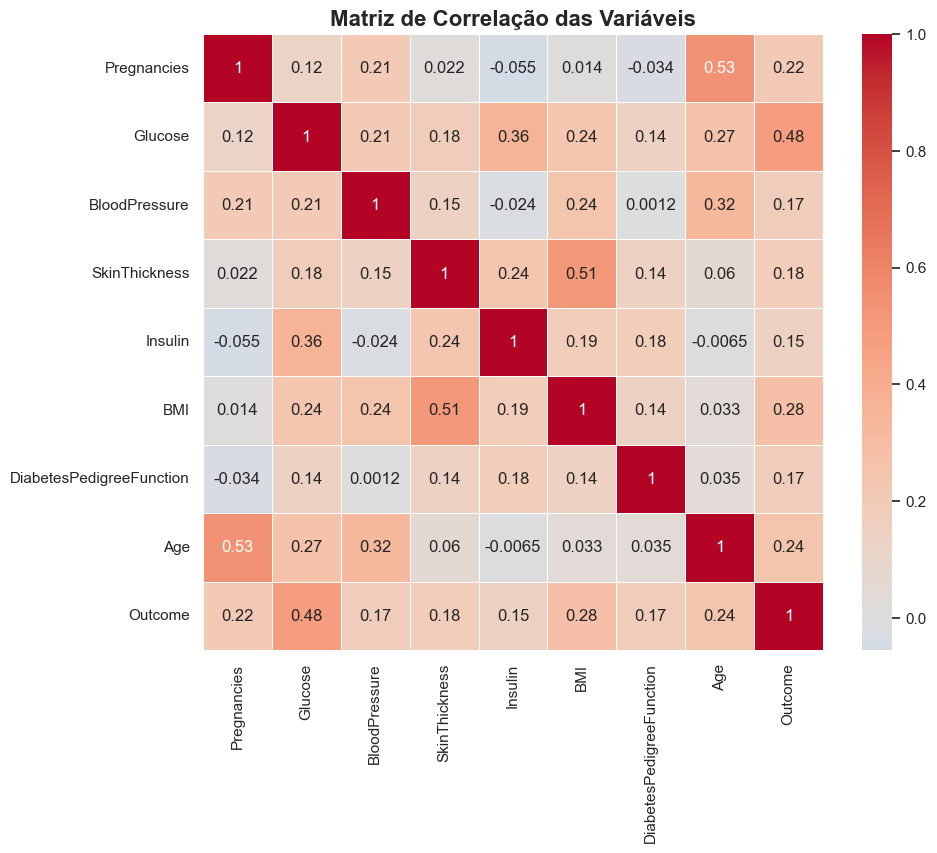

In [291]:
# Mapa de calor de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(df_clean.corr(), annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Matriz de Correlação das Variáveis', fontsize=16, fontweight='bold')
plt.show()

### 4. Modelos

#### 4.1 Preparação dos dados

In [292]:
X = df_clean.drop(['Outcome'], axis=1)
y = df_clean['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scalers diferentes para cada modelo (melhor prática em dados médicos)
scaler_robust = RobustScaler()
scaler_standard = StandardScaler()

#### 4.2 Treinamento dos modelos

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

resultados_finais = {}
melhores_params = {}

modelos_config = {
    'Regressão Logística': {
        'model': Pipeline([
            ('scaler', RobustScaler()),
            ('clf', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
        ]),
        'params': {
            'clf__C': [0.01, 0.1, 1, 10, 50],
            'clf__solver': ['liblinear', 'lbfgs']
        }
    },

    'Random Forest': {
        'model': Pipeline([
            ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
        ]),
        'params': {
            'clf__max_depth': [None, 4, 6, 8, 10, 12],
            'clf__min_samples_leaf': [1, 2, 5, 10],
            'clf__min_samples_split': [2, 5, 10],
            'clf__criterion': ['gini', 'entropy']
        }
    },

    'SVM': {
        'model': Pipeline([
            ('scaler', RobustScaler()),
            ('clf', SVC(random_state=42, class_weight='balanced'))
        ]),
        'params': {
            'clf__C': [0.1, 1, 10, 50, 100],
            'clf__kernel': ['rbf'],  
            'clf__gamma': ['scale', 'auto', 0.01, 0.1, 1]
        }
    },

    'Rede Neural (MLP)': {
        'model': Pipeline([
            ('scaler', StandardScaler()),
            ('clf', MLPClassifier(max_iter=1000, early_stopping=True, random_state=42))
        ]),
        'params': {
            'clf__hidden_layer_sizes': [(50,), (100,), (100,50), (100,100), (150,100)],
            'clf__alpha': [0.0001, 0.001, 0.01, 0.1],
            'clf__learning_rate_init': [0.001, 0.005, 0.01, 0.05]
        }
    }
}

print("Iniciando GridSearch")
print("-" * 50)

for nome, config in modelos_config.items():
    print(f"Otimizando: {nome}...")
    
    grid = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=cv,
        scoring='accuracy',  
        n_jobs=-1,
        verbose=0
    )
    
    grid.fit(X_train, y_train)
    
    melhor_modelo = grid.best_estimator_
    melhores_params[nome] = grid.best_params_
    
    y_pred = melhor_modelo.predict(X_test)

    resultados_finais[nome] = {
        'y_pred': y_pred,
        'acc': accuracy_score(y_test, y_pred),
        'prec': precision_score(y_test, y_pred, zero_division=0),
        'rec': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0)
    }


print("-" * 50)
print("Otimização Concluída.")

df_metricas = pd.DataFrame({
    modelo: {
        'Acurácia': f"{vals['acc']:.4f}",
        'Precisão': f"{vals['prec']:.4f}",
        'Recall': f"{vals['rec']:.4f}",
        'F1-Score': f"{vals['f1']:.4f}",
    }
    for modelo, vals in resultados_finais.items()
}).T

print("\nDesempenho no Conjunto de Teste (Pós-Otimização):")
print(df_metricas)

print("\nMelhores Parâmetros Encontrados:")
for modelo, params in melhores_params.items():
    print(f"{modelo}: {params}")


Iniciando GridSearch
--------------------------------------------------
Otimizando: Regressão Logística...
Otimizando: Random Forest...
Otimizando: SVM...
Otimizando: Rede Neural (MLP)...
--------------------------------------------------
Otimização Concluída.

Desempenho no Conjunto de Teste (Pós-Otimização):
                    Acurácia Precisão  Recall F1-Score
Regressão Logística   0.7244   0.5968  0.6727   0.6325
Random Forest         0.7756   0.6923  0.6545   0.6729
SVM                   0.7436   0.6190  0.7091   0.6610
Rede Neural (MLP)     0.7179   0.5663  0.8545   0.6812

Melhores Parâmetros Encontrados:
Regressão Logística: {'clf__C': 1, 'clf__solver': 'lbfgs'}
Random Forest: {'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
SVM: {'clf__C': 1, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}
Rede Neural (MLP): {'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (100, 50), 'clf__learning_rate_init': 0.05}


#### 4.3 Resultados

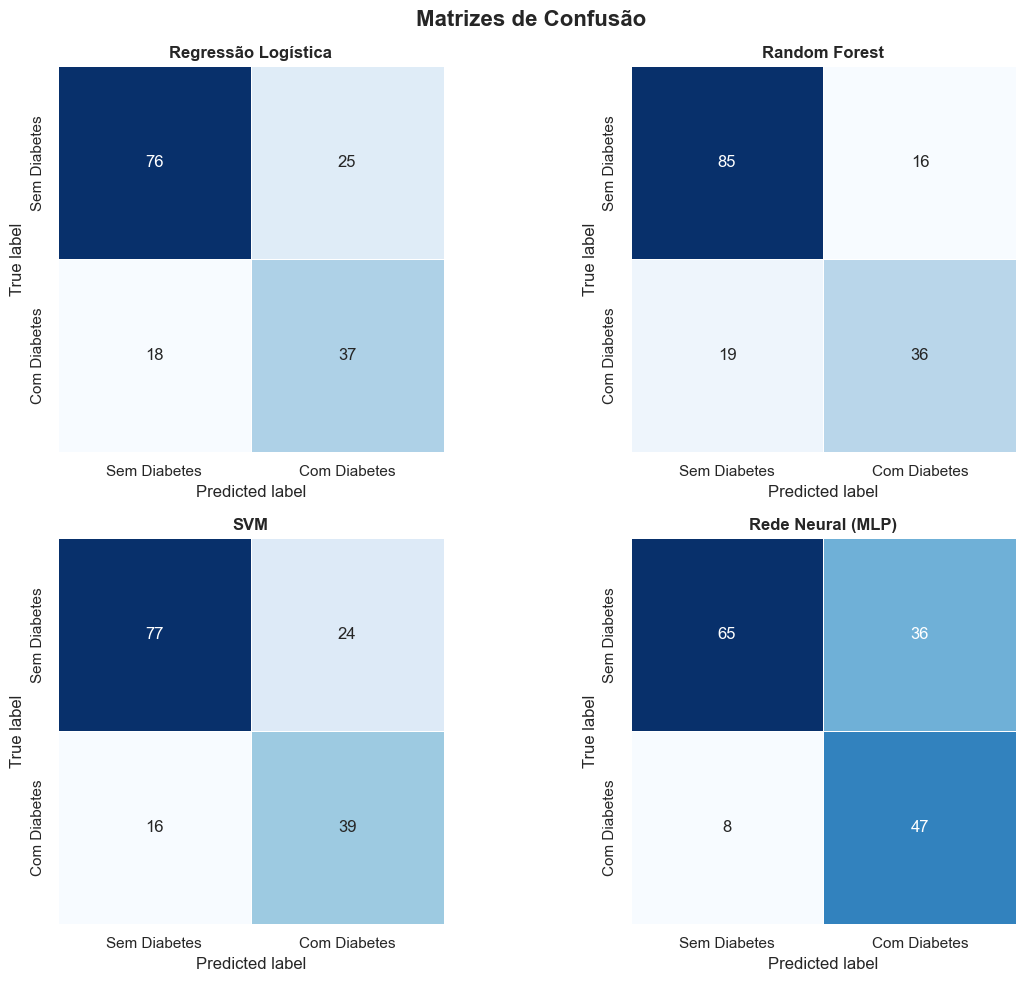

In [294]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, (nome, res) in enumerate(resultados_finais.items()):
    cm = confusion_matrix(y_test, res['y_pred'])
    
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        square=True,
        xticklabels=['Sem Diabetes', 'Com Diabetes'],
        yticklabels=['Sem Diabetes', 'Com Diabetes'],
        ax=axes[idx],
        linewidths=0.5,      
        linecolor="white"
    )

    axes[idx].set_title(nome, fontweight='bold')
    axes[idx].set_xlabel("Predicted label")
    axes[idx].set_ylabel("True label")

plt.suptitle("Matrizes de Confusão", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()


#### 4.5 Comparação visual das métricas

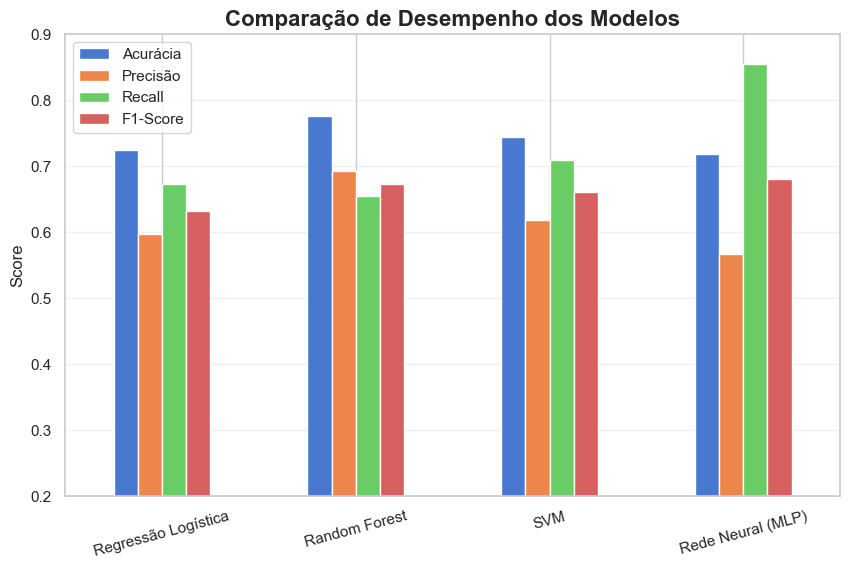

In [295]:
metricas_plot = df_metricas.astype(float)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
metricas_plot.plot(kind='bar', ax=ax)
ax.set_title('Comparação de Desempenho dos Modelos', fontsize=16, fontweight='bold')
ax.set_ylabel('Score')
ax.set_ylim(0.2, 0.9)
ax.legend(loc='upper left')
plt.xticks(rotation=15)
plt.grid(axis='y', alpha=0.3)
plt.show()